In [ ]:
import os
from dotenv import load_dotenv
from pathlib import Path
import streamlit as st

# Load .env from the project root
env_path = Path('..') / '.env'  # Go one directory up to locate .env
load_dotenv(dotenv_path=env_path)
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']= st.secrets["EXTRA_Langchain_key"]
# os.environ['LANGCHAIN_PROJECT']="pr-advanced-theism-85"

# Chunk Retrieval using Metadata filter

In [ ]:
from langchain_openai import ChatOpenAI
from utils.chunk_doc import get_retriever, get_vector_store



# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     api_key=st.secrets["OpenAI_key"]
# )

vector_store = get_vector_store()

query = "What is Insertion Sort?"
metadata_filter = {"keywords": "Insertion"}
# response = vector_store.search(query,search_type="mmr", k=5, fetch_k=10)
# print(response)
found_docs = vector_store.max_marginal_relevance_search(query, filter=metadata_filter)
print(found_docs)
for i, doc in enumerate(found_docs):
    print(f"{i + 1}.", doc.page_content, "\n")

# Keyword Generation using LLAMA 3.2

In [ ]:
from langchain_ollama import OllamaLLM
from langchain_openai import ChatOpenAI
from utils.custom_embeddings import MyEmbeddings
from utils.chunk_doc import get_vector_store

embedding_func = MyEmbeddings()

# Initialize Ollama LLM
llm = OllamaLLM(
    # model="gemma2:2b",
    model = "llama3.2:latest",
    base_url="http://localhost:11434"  # Adjust this URL if needed
)

from langchain_core.prompts import ChatPromptTemplate

# Define a prompt template for Ollama to generate keywords
# Gemma2:2b Template
# keyword_prompt_template = ChatPromptTemplate.from_messages(
#     [
#         ("system", "You are an assistant that generates keywords for a chunk of text. The keywords must be single words or two-word phrases. Format the output as: ['keyword1', 'keyword2']"),
#         ("human", "Extract relevant keywords for the following chunk:\n\n{chunk_text}")
#     ]
# )

# Llama3.2:1b Template
keyword_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an assistant that generates keywords for a chunk of text. "
                   "Your response should only contain keywords in json format."),
        ("human", "Extract relevant keywords from the following chunk:\n\n{chunk_text}")
    ]
)

chain = keyword_prompt_template | llm

# Initialize Vector Store
vector_store = get_vector_store()

def split_chunks():
    try:
        from pathlib import Path
        from langchain_core.documents import Document
        from langchain_text_splitters import RecursiveCharacterTextSplitter as Rec
        
        # Path to markdown directory
        md_dir = Path("../data/md/")
        chunk_id_counter = 1  # Initialize a counter for unique chunk IDs
        ids = []
        documents = []

        # Loop through all markdown files in the md directory
        for md_file in md_dir.glob("*.md"):
            with open(md_file, "r") as f:
                md_content = f.read()

            # Chunk the markdown content
            text_splitter = Rec(
                chunk_size=2000,
                chunk_overlap=500,
                length_function=len,
                add_start_index=True
            )
            chunks = text_splitter.split_text(md_content)
            
            for chunk in chunks:
                # Generate keywords for the chunk using Ollama
                response = chain.invoke({"chunk_text": chunk})
                
                import json
                # Convert the JSON string to a Python dictionary
                dictionary_output = json.loads(response)

                # Access the "keywords" list
                keywords_list = dictionary_output["keywords"]
                
                # Create a Document object with metadata for the chunk, including keywords
                document_to_add = Document(
                    page_content=chunk,
                    metadata={"source": str(md_file), "keywords": str(keywords_list)}
                )
                
                documents.append(document_to_add)
                ids.append(str(chunk_id_counter))  # Add document ID to the list
                chunk_id_counter += 1  # Increment the ID counter
        
        # Assuming vector_store is defined and initialized elsewhere
        vector_store.add_documents(documents=documents, ids=ids)
    except Exception as e:
        print(f"Error: {e}")
        
if __name__ == "__main__":
    # split_chunks()
    
    # print(response)

    response = chain.invoke({"chunk_text": """ ###### 2.1.1 Insertion

In general when people talk about insertion with respect to linked lists of any
form they implicitly refer to the adding of a node to the tail of the list. When
you use an API like that of DSA and you see a general purpose method that
adds a node to the list, you can assume that you are adding the node to the tail
of the list not the head.

Adding a node to a singly linked list has only two cases:

1. head = in which case the node we are adding is now both the head and
_∅_
_tail of the list; or_

2. we simply need to append our node onto the end of the list updating the
_tail reference appropriately._

1) algorithm Add(value)
2) **Pre: value is the value to add to the list**
3) **Post: value has been placed at the tail of the list**
4) _n_ node(value)
_←_
5) **if head =**
_∅_
6) _head_ _n_
_←_
7) _tail_ _n_
_←_
8) **else**
9) _tail.Next_ _n_
_←_
10) _tail_ _n_
_←_
11) **end if**
12) end Add

As an example of the previous algorithm consider adding the following sequence of integers to the list: 1, 45, 60, and 12, the resulting list is that of
Figure 2.2.

###### 2.1.2 Searching

Searching a linked list is straightforward: we simply traverse the list checking
the value we are looking for with the value of each node in the linked list. The
algorithm listed in this section is very similar to that used for traversal in 2.1.4.
_§_


-----

_CHAPTER 2. LINKED LISTS_ 11

1) algorithm Contains(head, value)
2) **Pre: head is the head node in the list**
3) _value is the value to search for_
4) **Post: the item is either in the linked list, true; otherwise false**
5) _n_ _head_
_←_
6) **while n** = **and n.Value** = value
_̸_ _∅_ _̸_
7) _n_ _n.Next_
_←_
8) **end while**
9) **if n =**
_∅_
10) **return false**
11) **end if**
12) **return true**
13) end Contains

###### 2.1.3 Deletion

Deleting a node from a linked list is straightforward but there are a few cases
we need to account for:

1. the list is empty; or

2. the node to remove is the only node in the linked list; or

3. we are removing the head node; or

4. we are removing the tail node; or

5. the node to remove is somewhere in between the head and tail; or

6. the item to remove doesn’t exist in the linked list

The algorithm whose cases we have described will remove a node from anywhere within a list irrespective of whether the node is the head etc. If you know
that items will only ever be removed from the head or tail of the list then you
can create much more concise algorithms. In the case of always removing from
the front of the linked list deletion becomes an O(1) operation."""})

    # print(dictionary_output)
    print(response)

# Multi Query

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from utils.custom_embeddings import MyEmbeddings
import os
import streamlit as st
from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaLLM
from utils.chunk_doc import get_vector_store

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']= st.secrets["EXTRA_Langchain_key"]
os.environ['LANGCHAIN_PROJECT']="chatbot-test"



embedding_func = MyEmbeddings()


# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by a single newline. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser

gpt4 = ChatOpenAI(
    model="gpt-4o-mini",
    # api_key=os.environ.get("OPENAI_API_KEY"),
    api_key=st.secrets["OpenAI_key"],
    temperature=0
)

# llm = OllamaLLM(model="gemma2:2b", base_url="http://localhost:11434")

generate_queries = (
    prompt_perspectives 
    | gpt4
    | StrOutputParser() 
    | (lambda x: [line for line in x.split("\n") if line.strip() != ""])  # Ensure empty strings are removed
)

from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Initialize ChromaDB client
vector_store = get_vector_store()

retriever = vector_store.as_retriever()

# Retrieve
question = "What is Insertion Sort?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
# print(docs)
len(docs)

from operator import itemgetter

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | gpt4
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})


# RAG-Fusion

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from utils.custom_embeddings import MyEmbeddings
import os
from langchain_openai import ChatOpenAI
from utils.chunk_doc import get_retriever, get_vector_store


embedding_func = MyEmbeddings()


# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.environ.get("OPENAI_API_KEY"),
    # api_key=st.secrets["OpenAI_key"],
    temperature=0
)

generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

# Initialize Vector Store
# vector_store = get_vector_store()

retriever = get_retriever()

# Retrieve
question = "What is Insertion Sort?"
retrieval_chain_rag_fusion  = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain.invoke({"question":question})
# print(docs)
len(docs)

from operator import itemgetter

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})


# Retrieval Check

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from utils.custom_embeddings import MyEmbeddings
import os
from langchain_openai import ChatOpenAI
from utils.chunk_doc import get_retriever, get_vector_store
from prompt_templates.retrieval_check import get_rc_chain
import streamlit as st
from langchain_core.messages import HumanMessage
from utils.image_processing import process_image, encode_image
from prompt_templates.image_template import get_image_chain

embedding_func = MyEmbeddings()

def read_image_bytes(image_path):
    with open(image_path, 'rb') as image_file:
        return image_file.read()


from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    model="gpt-4o-mini",
    # api_key=os.environ.get("OPENAI_API_KEY"),
    api_key=st.secrets["OpenAI_key"],
    temperature=0
)
import base64


img = read_image_bytes('46bfac9.png')


image_data = base64.b64encode(img).decode("utf-8")



image_chain = get_image_chain(llm)

message_content = [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}
                    }
                ]

prompt = ChatPromptTemplate(
    [
        ("system", ""),
        (
            "human",
            [
                {
                    "type": "text",
                    "text": "Describe the image provided",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": "data:image/jpeg;base64,{image_data}"},
                }
            ],
        ),
    ]
)
chain = prompt | llm

response = chain.invoke({"image_data": image_data})
print(response.content)



In [ ]:
# Retrieve
question = "Okay thank you so much thats all?"
retrieval_chain  = get_rc_chain(llm)
response = retrieval_chain.invoke({"input":question})
print(response)
print(response.content)

# DB

In [ ]:
from utils.db_connection import ChatDatabase

db = ChatDatabase('chat.db')

result = db.load_chat_history(chat_id="638c132f-ecdb-4357-9b8c-3dff0c396cb1_1",user_id="638c132f-ecdb-4357-9b8c-3dff0c396cb1")

for msg in result:
    print(f'{msg["role"]}: {msg["content"]}\n')



In [5]:
from datetime import datetime, timedelta
def should_analyze_user_level(user_id):
    """Determine if it's time to analyze the user's level."""
    last_analysis = db.get_last_analysis_timestamp(user_id)
    
    # If no previous analysis, definitely analyze
    if last_analysis is None:
        db.update_analysis_timestamp(user_id)
        return False
        
    
    # Get recent interactions count
    recent_history = db.load_chat_history(user_id, f"{user_id}_1")
    last_analysis_datetime = datetime.fromisoformat(last_analysis) if isinstance(last_analysis, str) else last_analysis
    
    # Count only messages after last analysis
    interaction_count = 0
    for message in recent_history:
        message_timestamp = message.get("timestamp")
        
        # Convert string timestamp to datetime
        message_datetime = datetime.fromisoformat(message_timestamp)
        
        
        if message_datetime and message["role"] == "user":
            if message_datetime > last_analysis_datetime:
                interaction_count += 1
    
    # Criteria: At least 7 days and 10 interactions since last analysis
    time_threshold = datetime.now() - last_analysis_datetime >= timedelta(days=7)
    interaction_threshold = interaction_count >= 5
    # print("Last Analysis: ", last_analysis_datetime)
    # print("Current Time: ", datetime.now())
    # print("Time Threshold: ", time_threshold)
    # print("Interaction Count: ", interaction_count)
    print("Should Analyze: ", time_threshold or interaction_threshold)
    print("Time Threshold: ", time_threshold)
    print("Interaction Threshold: ", interaction_threshold)
    
    return time_threshold or interaction_threshold

should_analyze_user_level("638c132f-ecdb-4357-9b8c-3dff0c396cb1")

Should Analyze:  False
Time Threshold:  False
Interaction Threshold:  False


False

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
from utils.db_connection import ChatDatabase

db = ChatDatabase('chat.db')

chat_history = db.load_chat_history("638c132f-ecdb-4357-9b8c-3dff0c396cb1", "638c132f-ecdb-4357-9b8c-3dff0c396cb1_1")
messages = []
for message in chat_history:
    if message["role"] == "user":
        messages.append(HumanMessage(content=message["content"]))
        print(message["content"])
    else:
        messages.append(AIMessage(content=message["content"]))
        print(message["content"])
        


insertion sort?
**1. Simple Definition:**  
Insertion sort is like sorting a hand of playing cards. You take one card at a time and place it in the right position among the cards you’ve already sorted. 

**2. Basic Step-by-Step Explanation with Example:**  
Let’s say we have a small list of numbers: [4, 3, 2, 1, 5]. Here’s how insertion sort works:  
- Start with the first number (4). It’s already sorted.  
- Take the next number (3). Compare it with 4. Since 3 is smaller, move 4 to the right and place 3 in the first position: [3, 4, 2, 1, 5].  
- Next, take 2. Compare it with 4 and 3, moving them to the right, and place 2 at the start: [2, 3, 4, 1, 5].  
- Now, take 1. Move 2, 3, and 4 to the right and place 1 at the start: [1, 2, 3, 4, 5].  
- Finally, 5 is already in the right place, so the sorted list is [1, 2, 3, 4, 5].

**3. Very Basic Time Complexity:**  
- Fast when the list is nearly sorted.  
- Slow for a completely random list.

**4. One Simple Real-World Application:**  
In

## Edit User Details

In [ ]:
db.save_user_data("6fcf537a-8e1e-496b-be68-84841722fa57","","elroy7602@gmail.com")

## Delete All

In [ ]:

users = db.get_all_users()

for user in users:
    print(user['user_id']," ",db.get_user_level(user['user_id']))


## Delete Specific User

In [ ]:
db.delete_user("5b2429f2-7dde-4469-8b88-75910f2e5a5b")

In [ ]:
user_level = "intermediate"
levels = ("Beginner", "Intermediate", "Advanced")
print(levels.index(user_level.capitalize()))

In [ ]:
def get_user_level_tool(user_id: str) -> str:
    """Get user level for given user_id"""
    try:
        user_level = db.get_user_level(user_id)
        return f"Current user level is {user_level}." if user_level else "User not found."
    except Exception as e:
        return f"Error retrieving user level: {str(e)}"
    

hello = get_user_level_tool("6fcf537a-8e1e-496b-be68-84841722fa57")

print(hello)

## Reset Analysis Timestamp

In [ ]:
db.reset_analysis_timestamp("638c132f-ecdb-4357-9b8c-3dff0c396cb1")

True

## Get User Topics

In [ ]:
import json

result = db.get_user_topics(user_id="638c132f-ecdb-4357-9b8c-3dff0c396cb1")
print(json.loads(result))

print()


{'Sorting Algorithms': ['Insertion Sort', 'Bubble Sort', 'Quick Sort', 'Merge Sort'], 'Algorithm Performance': [], 'Recursion': []}



: 

## Update User Topics

In [3]:
db.update_user_topics(user_id="0122656d-8999-4ae9-89d2-5f4d6c2ebd02",topics="{}")

True

# Using Tools with Langchain LCEL


In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from utils.custom_embeddings import MyEmbeddings
import streamlit as st
from langchain_openai import ChatOpenAI
from utils.chunk_doc import get_retriever, get_vector_store

llm = ChatOpenAI(
        model_name="gpt-4o-mini", 
        temperature=0, 
        streaming=True, 
        api_key=st.secrets["OpenAI_key"]
    )

from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

llm_with_tools = llm.bind_tools(tools)

from langchain_core.messages import HumanMessage

query = "What is 3 * 12? Also, what is 11 + 49?"

messages = [HumanMessage(query)]

ai_msg = llm_with_tools.invoke(messages)

print(ai_msg.tool_calls)

messages.append(ai_msg)




[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_StJMon95i5N4wk1gyNP4oyOr', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'call_l9XGcLbfxcdPv4w09zg1hzNR', 'type': 'tool_call'}]


In [7]:
for tool_call in ai_msg.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

messages

[HumanMessage(content='What is 3 * 12? Also, what is 11 + 49?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_StJMon95i5N4wk1gyNP4oyOr', 'function': {'arguments': '{"a": 3, "b": 12}', 'name': 'multiply'}, 'type': 'function'}, {'index': 1, 'id': 'call_l9XGcLbfxcdPv4w09zg1hzNR', 'function': {'arguments': '{"a": 11, "b": 49}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c'}, id='run-6f538260-5986-4429-af39-b01af767677a-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_StJMon95i5N4wk1gyNP4oyOr', 'type': 'tool_call'}, {'name': 'add', 'args': {'a': 11, 'b': 49}, 'id': 'call_l9XGcLbfxcdPv4w09zg1hzNR', 'type': 'tool_call'}]),
 ToolMessage(content='36', name='multiply', tool_call_id='call_StJMon95i5N4wk1gyNP4oyOr'),
 ToolMessage(content='60', name='add', tool_call_id='cal

In [8]:
llm_with_tools.invoke(messages)

AIMessage(content='The result of \\(3 \\times 12\\) is 36, and the result of \\(11 + 49\\) is 60.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63'}, id='run-9c6964b2-9be9-4755-bc21-d71b95e0d175-0')

# Current Retrieval Tool for Langgraph [Important]

Initializing retriever...


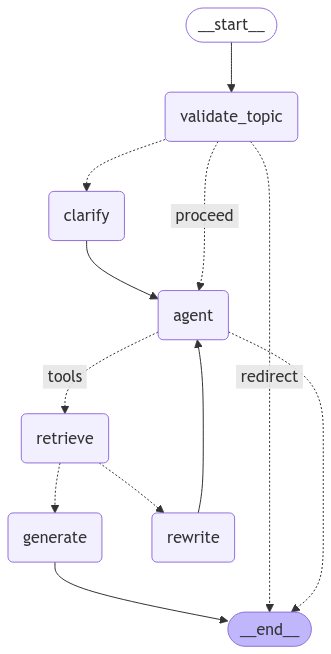

In [3]:
from langchain.tools.retriever import create_retriever_tool
from utils.chunk_doc import get_retriever
import os
import streamlit as st
from langchain import hub
from typing import Annotated, Literal, Sequence, Any, Dict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatMessagePromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from model import llm_selected

# TODO
# LLM still unsure how to respond to Thank you, Goodbye, etc. Hi, still okay i guess
# Keep testing!
# Change clarification method

# Initialize the retriever
print("Initializing retriever...")
retriever = get_retriever()

# Create the retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_documents",
    """Search and return relevant documents based on user's query."""
)

# Add the retriever tool to the list of tools
tools = [retriever_tool]

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_level: str

def validate_dsa_question(state) -> dict[str, Any]:
    """
    Validates input to either handle DSA questions or engage in friendly conversation,
    while redirecting other technical questions.
    
    Args:
        state: Current state containing messages and user_level
        
    Returns:
        dict[str, Any]: Dictionary containing:
            - messages: List of conversation messages
            - user_level: User's current level
            - next: Literal["proceed", "redirect"] indicating next action
    """
    messages = state["messages"]
    question = messages[-1].content
    user_level = state["user_level"]
    
    class ValidationResult(BaseModel):
        message_type: str = Field(
            description="Type of message: 'dsa', 'pleasantry', or 'other'",
        )
        response: str = Field(
        description="Customized response for pleasantries or redirects",
        default=""  # Provide dynamic responses instead of a static default
        )

    # Get context from previous messages if they exist
    context_messages = messages[-6:-1] if len(messages) > 6 else messages[:-1]
    conversation_context = "\n".join([
        f"{'User: ' if isinstance(m, HumanMessage) else 'Assistant: '}{m.content}"
        for m in context_messages
    ])
    
    prompt = PromptTemplate(
        template="""Analyze the input as a friendly DSA tutor:

Previous conversation:
{context}

Current input: {question}

Classify the input into one of three categories:

1. 'dsa' - Questions directly about:
   - Data Structures (arrays, linked lists, trees, graphs, etc.)
   - Algorithms (sorting, searching, traversal, etc.)
   - Algorithm analysis (complexity, Big O notation)
   - DSA implementation
   - DSA problem-solving

2. 'pleasantry' - Friendly conversation:
   - Greetings (hi, hello, hey)
   - Thanks/gratitude
   - Goodbyes
   - Emotional responses ("that makes sense", "I'm confused")
   - Small encouragements ("got it", "okay I understand")
   
3. 'other' - Non-DSA technical content:
   - General programming
   - Math questions
   - Other CS topics
   - Non-technical questions

For pleasantries: Respond naturally like a friendly tutor
For other: Redirect to DSA while being encouraging

Return:
1. message_type: 'dsa', 'pleasantry', or 'other'
2. response: Natural response for pleasantries or friendly redirect for other""",
        input_variables=["context", "question"]
    )
    
    try:
        model = ChatOpenAI(
            model_name="gpt-4o-mini", 
            temperature=0.4,  # Slightly higher temperature for more natural responses
            streaming=True, 
            api_key=st.secrets["OpenAI_key"]
        )
        chain = prompt | model.with_structured_output(ValidationResult)
        result = chain.invoke({
            "context": conversation_context,
            "question": question
        })
        
        # Add refined responses for pleasantries or "other"
        if result.message_type == "pleasantry":
            if "thanks" in question.lower():
                result.response = "You're very welcome! Let me know if there's anything else you'd like to explore about DSA."
            elif any(greet in question.lower() for greet in ["hi", "hello", "hey"]):
                result.response = "Hi there! I'm here to help with any questions about data structures and algorithms. What would you like to learn about today?"
            elif any(farewell in question.lower() for farewell in ["bye", "goodbye"]):
                result.response = "Take care! Feel free to reach out whenever you're ready to dive into DSA again!"

        elif result.message_type == "other":
            result.response = ("That's an interesting topic, but my expertise is in data structures and algorithms. "
                               "I'd be happy to help you explore concepts like trees, graphs, or sorting algorithms. "
                               "Let me know what you'd like to dive into!")
        
        # Determine the next step
        if result.message_type == "dsa":
            return {
                "messages": messages,
                "user_level": user_level,
                "next": "proceed"
            }
        else:  # pleasantry or other
            return {
                "messages": [*messages, AIMessage(content=result.response)],
                "user_level": user_level,
                "next": "redirect"
            }
            
    except Exception as e:
        print(f"Validation error: {str(e)}")
        # On error, proceed with original message
        return {
            "messages": messages,
            "user_level": user_level,
            "next": "proceed"
        }

def clarify_question(state):
    """
    Clarifies ambiguous questions by maintaining conversation context,
    with improved handling of pronoun references to DSA concepts.
    """
    print("\n=== DEBUG: CLARIFY NODE ===")
    messages = state["messages"]
    current_question = messages[-1].content
    print(f"Original question: {current_question}")
    
    # Get the last 3 exchanges (up to 6 messages) for relevant context
    context_messages = messages[-6:-1] if len(messages) > 6 else messages[:-1]
    conversation_context = "\n".join([
        f"{'User: ' if isinstance(m, HumanMessage) else 'Assistant: '}{m.content}"
        for m in context_messages
    ])
    
    class ClarificationResult(BaseModel):
        clarified_question: str = Field(
            description="The clarified version of the question with pronouns replaced by their referents",
            default=""  # Provide empty string as default
        )
        referenced_concept: str = Field(
            description="The main DSA concept being referenced from previous context",
            default=""  # Provide empty string as default
        )
    
    model = ChatOpenAI(
        model_name="gpt-4o-mini", 
        temperature=0, 
        streaming=True, 
        api_key=st.secrets["OpenAI_key"]
    )
    llm_with_clarification = model.with_structured_output(ClarificationResult)
    
    prompt = PromptTemplate(
        template="""
You are a DSA question processor. Transform user's prompt into clear, context-aware queries.

OBJECTIVE: Rewrite user's prompt to include relevant context from chat history while maintaining original intent.

Previous conversation:
{context}

Current question: {question}

TRANSFORMATION RULES:
1. Replace pronouns with specific references
   Before: "How do I implement it?"
   After: "How do I implement a binary search tree?"

2. Include relevant context
   Before: "What about the time complexity?"
   After: "What is the time complexity of quicksort's partitioning step?"

3. Maintain technical precision
   Before: "How does the fast one work?"
   After: "How does the O(n log n) merge sort algorithm work?"

4. Keep original meaning
   Do NOT add assumptions or change the question's scope

Return ONLY the reformulated question without explanation.

""",
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_clarification
    
    try:
        result = chain.invoke({
            "context": conversation_context,
            "question": current_question
        })
        
        # For non-DSA questions or greetings, use original question
        if not result.needs_clarification:
            print("No clarification needed - using original question")
            return {"messages": messages, "user_level": state["user_level"]}
            
        # For questions needing clarification, verify we have the clarified version
        if result.needs_clarification and result.clarified_question:
            print(f"Referenced concept: {result.referenced_concept}")
            print(f"Clarified to: {result.clarified_question}")
            return {"messages": [HumanMessage(content=result.clarified_question)], "user_level": state["user_level"]}
        else:
            print("No clarification needed")
            return {"messages": messages, "user_level": state["user_level"]}
            
    except Exception as e:
        print(f"Error in clarification: {str(e)}")
        # On error, proceed with original question
        return {"messages": messages, "user_level": state["user_level"]}

def agent(state):
    """
    Invokes the agent model to generate a response based on confidence level.
    
    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    # System message that enforces confidence-based retrieval
    system_message = """You are a DSA expert assistant. For every question:

1. First, assess your confidence in providing a complete, accurate answer:
   - Consider if you need specific implementation details
   - Consider if you need exact complexity analysis
   - Consider if you need specific examples or edge cases

2. If your confidence is less than 90%%:
   - ALWAYS use the retrieve_documents tool
   - Base your answer on the retrieved information
   - Acknowledge when using retrieved information

3. If your confidence is 90%% or higher:
   - You may answer directly from your knowledge
   - Still use the tool if additional detail would be helpful
   - Mention that you're confident in your direct answer

4. Always be explicit about tool usage:
   - "Let me check our reference materials for specific details..."
   - "I'm very confident about this, but let me verify some details..."
   - "This requires checking our documentation for precise information..."

Remember: It's better to verify with the tool than risk providing incomplete or inaccurate information."""

    # Prepare messages with system instruction
    full_messages = [
        HumanMessage(content=system_message),
        *messages
    ]
    
    # Initialize model with tools
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True, api_key=st.secrets["OpenAI_key"])
    model = model.bind_tools(tools)
    
    # Get response
    response = model.invoke(full_messages)
    
    return {"messages": [response]}

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Enhanced grading system for retrieved DSA documents.
    
    Evaluates:
    1. Relevance to the question
    2. Completeness of the answer
    3. Technical accuracy
    4. Need for clarification
    
    Returns:
    - "generate": When documents are good enough to generate response
    - "rewrite": When documents aren't relevant enough
    - "clarify": When question needs clarification
    """
    print("---ENHANCED GRADING SYSTEM---")
    
    class GradeResult(BaseModel):
        relevance_score: float = Field(description="0-1 score for topic relevance")
        completeness_score: float = Field(description="0-1 score for answer completeness")
        technical_accuracy: float = Field(description="0-1 score for technical accuracy")
        reasoning: str = Field(description="Explanation for the grading decision")

    messages = state["messages"]
    question = messages[0].content
    retrieved_docs = messages[-1].content

    # Define the grading prompt
    prompt = PromptTemplate(
        template="""You are a DSA expert grading retrieved content.

Question: {question}

Retrieved Content:
{content}

Grade this content on:
1. Relevance: Does it directly address the DSA concepts in the question?
2. Completeness: Does it cover all aspects needed for a good answer?
3. Technical Accuracy: Is the DSA information correct and precise?
4. Clarity: Is the question clear or needs clarification?

Example DSA concepts to check for:
- Data structure definitions and properties
- Algorithm steps and processes
- Time/space complexity mentions
- Implementation details
- Common use cases and examples

Return scores as decimals between 0 and 1, where:
- 0.0-0.3: Poor
- 0.4-0.6: Moderate
- 0.7-1.0: Good

Also explain your reasoning.""",
        input_variables=["question", "content"]
    )

    try:
        # Initialize model with lower temperature for consistent grading
        model = ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
            streaming=True,
            api_key=st.secrets["OpenAI_key"]
        )
        
        # Grade with structured output
        chain = prompt | model.with_structured_output(GradeResult)
        result = chain.invoke({
            "question": question,
            "content": retrieved_docs
        })
        
        print(f"Grading Results:\n"
              f"Relevance: {result.relevance_score:.2f}\n"
              f"Completeness: {result.completeness_score:.2f}\n"
              f"Technical Accuracy: {result.technical_accuracy:.2f}\n")
            
        # Calculate weighted average score
        weighted_score = (
            result.relevance_score * 0.4 +      # Relevance is most important
            result.completeness_score * 0.3 +    # Completeness next
            result.technical_accuracy * 0.3      # Technical accuracy equally important
        )
        
        # Decision thresholds
        GOOD_THRESHOLD = 0.65
        
        if weighted_score >= GOOD_THRESHOLD:
            print("---DECISION: CONTENT GOOD ENOUGH TO GENERATE---")
            return "generate"
        else:
            print("---DECISION: NEED TO REWRITE QUERY---")
            return "rewrite"

    except Exception as e:
        print(f"Grading error: {str(e)}")
        # On error, default to rewrite for safety
        return "rewrite"
    
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])
    response = model.invoke(msg)
    return {"messages": [response]}

def generate(state):
    """Generate response based on retrieved content and question"""
    print("\n=== DEBUG: GENERATE NODE ===")
    messages = state["messages"]
    print("Messages: ", state["messages"])
    
    # Find the last actual question by looking for the last HumanMessage
    # that triggered the retrieval flow
    question = None
    
    for msg in messages:
        if isinstance(msg, HumanMessage):
            question = msg.content
            
    if not question:
        return {
            "messages": [AIMessage(content="I couldn't properly process your question. Could you please rephrase it?")],
            "user_level": state["user_level"]
        }
        
    user_level = state["user_level"]
    docs = messages[-1].content  # Retrieved content is always last
    
    print(f"Generate received question: {question}")
    print(f"User level: {user_level}")
    # print(f"Docs length: {len(docs) if docs else 'None'}")
    
    if not docs or len(docs.strip()) < 10:
        print("---NO CONTENT TO GENERATE FROM---")
        return {"messages": [AIMessage(content="I apologize, but I couldn't find relevant information to answer your question. Please try rephrasing it.")], "user_level": state["user_level"]}
        
    try:
        llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True, api_key=st.secrets["OpenAI_key"])
        
        # prompt = PromptTemplate(
        #     template="""Answer based on the following context. If context is insufficient, say so clearly.
        #     Question: {question}
        #     User Level: {user_level}
        #     Context: {context}
            
        #     If you don't find specific information about the topic, you can provide a general explanation based on your knowledge, but clearly state that you're doing so.""",
        #     input_variables=["context", "question", "user_level"],
        # )
        prompt = PromptTemplate(
            input_variables=['context', 'question','user_level'], 
            input_types={}, 
            partial_variables={}, 
            template="""You are a DSA expert tutor. Adapt your teaching style to the user's level while maintaining technical accuracy.

Current User Level: {user_level}

• BEGINNER LEVEL APPROACH:
  • Use simple analogies and metaphors
    • Compare arrays to parking lots
    • Explain stacks like plates in a cafeteria
    • Describe trees as family trees
  • Focus on basic understanding
    • Avoid complexity discussions
    • Use step-by-step explanations
    • Provide visual examples when possible
  • Keep language simple
    • Minimize technical jargon
    • Use everyday examples
    • Explain concepts interactively

• INTERMEDIATE LEVEL APPROACH:
  • Technical content focus
    • Include basic time/space complexity
    • Show implementation details
    • Provide code examples
  • Teaching methods
    • Compare different approaches
    • Explain basic trade-offs
    • Connect related concepts
  • Code implementation
    • Show practical examples
    • Discuss common patterns
    • Address basic optimizations

• ADVANCED LEVEL APPROACH:
  • Technical depth
    • Deep optimization discussions
    • Thorough edge case analysis
    • Performance considerations
  • System considerations
    • Memory/cache implications
    • Concurrency aspects
    • Scalability factors
  • Implementation focus
    • Advanced optimization techniques
    • System design impacts
    • Complex trade-offs

• UNIVERSAL RULES:
  • Stay within DSA scope
    • Redirect non-DSA questions politely
    • Focus on one concept at a time
    • Offer to explore related topics after
  • Use context appropriately
    • Start with provided context: "{context}"
    • Clearly indicate when using general knowledge
    • Stay within user's competency level
  • Maintain level-appropriate depth
    • Match technical depth to user level
    • Scale example complexity appropriately
    • Use suitable terminology

Question: {question}""")
        # prompt = hub.pull("rlm/rag-prompt")
        
        chain = prompt | llm | StrOutputParser()
        response = chain.invoke({
            "context": docs,
            "question": question,
            "user_level": user_level
        })
        
        print(f"Generated response length: {len(response)}")
        return {"messages": [AIMessage(content=response)], "user_level": state["user_level"]}
        
    except Exception as e:
        print(f"Error in generate: {str(e)}")
        return {"messages": [AIMessage(content="I encountered an error generating a response. Please try asking your question again.")], "user_level": state["user_level"]}

################################################################################################################
# Graph setup
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("validate_topic", validate_dsa_question)
workflow.add_node("clarify", clarify_question)
workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("rewrite", rewrite)

# Add edges
workflow.add_edge(START, "validate_topic")

# Modify validation to return three possible outcomes
workflow.add_conditional_edges(
    "validate_topic",
    lambda x: x["next"],
    {
        "proceed": "agent",
        "clarify": "clarify",
        "redirect": END
    }
)

# After clarification, go to agent
workflow.add_edge("clarify", "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite",
    }
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile graph
from test_templates.memory import memory
graph = workflow.compile()


from IPython.display import Image, display


display(Image(graph.get_graph().draw_mermaid_png()))

c:\Users\elroy\anaconda3\envs\chatbot\Lib\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.stats import fisher_exact
c:\Users\elroy\anaconda3\envs\chatbot\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Initializing retriever...


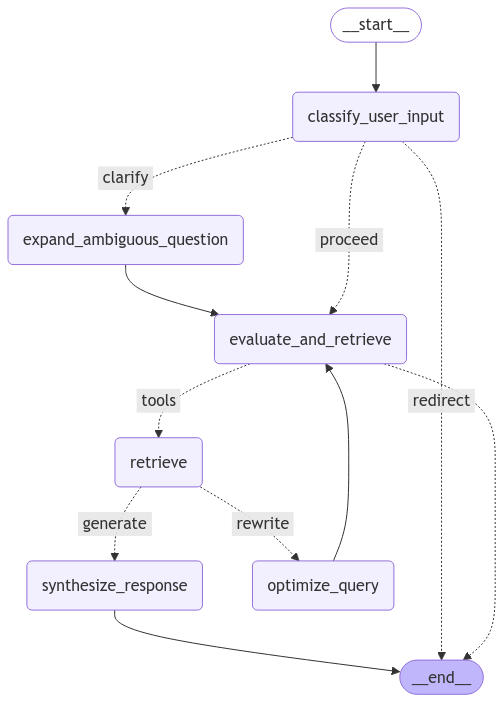

In [1]:
from langchain.tools.retriever import create_retriever_tool
from utils.chunk_doc import get_retriever
import os
import streamlit as st
from langchain import hub
from typing import Annotated, Literal, Sequence, Any, Dict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatMessagePromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# TODO
# Keep testing!
# Change clarification method

# Initialize the retriever
print("Initializing retriever...")
retriever = get_retriever()

# Create the retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_documents",
    """Search and return relevant documents based on user's query."""
)

# Add the retriever tool to the list of tools
tools = [retriever_tool]

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_level: str

def classify_user_input(state) -> dict[str, Any]:
    """Validates input to handle DSA questions, ensuring English-only interaction."""
    messages = state["messages"]
    question = messages[-1].content
    user_level = state["user_level"]
    
    
    class ValidationResult(BaseModel):
        message_type: str = Field(description="Type of message: 'dsa', 'pleasantry', 'non_english', or 'other'")
        response: str = Field(description="Response for non-DSA inputs")

    # First, check if current message is non-English
    language_prompt = PromptTemplate(
        template="""Analyze ONLY the current input for language:

Current input: {question}

Determine if this input contains ANY non-English text or characters.
Return:
1. message_type: 'non_english' if ANY non-English content is present, 'english' if input is entirely in English
2. response: "I can only communicate in English. Please rephrase your question in English." for non-English content""",
        input_variables=["question"]
    )
    
    try:
        model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.5, streaming=True, api_key=st.secrets["OpenAI_key"])
        language_chain = language_prompt | model.with_structured_output(ValidationResult)
        language_result = language_chain.invoke({"question": question})
        
        # If non-English is detected, return immediately
        if language_result.message_type == "non_english":
            return {
                "messages": [*messages, AIMessage(content="I can only communicate in English. Please rephrase your question in English.")],
                "user_level": user_level,
                "next": "redirect"
            }
            
        # If message is in English, proceed with full classification
        context_messages = messages[-6:-1] if len(messages) > 6 else messages[:-1]
        conversation_context = "\n".join([f"{'User: ' if isinstance(m, HumanMessage) else 'Assistant: '}{m.content}" 
                                        for m in context_messages])
        
        classification_prompt = PromptTemplate(
            template="""Analyze the English input as a friendly DSA tutor:

Previous conversation:
{context}

Current input: {question}

Classify the input into:

1. 'dsa' - Questions directly about:
- Data Structures (arrays, linked lists, trees, graphs, etc.)
- Algorithms (sorting, searching, traversal, etc.)
- Algorithm analysis (complexity, Big O notation)
- DSA implementation
- DSA problem-solving

2. 'pleasantry' - Friendly conversation:
- Greetings (hi, hello, hey)
- Thanks/gratitude
- Goodbyes
- Emotional responses ("that makes sense", "I'm confused")
- Small encouragements ("got it", "okay I understand")

3. 'other' - Non-DSA technical content:
- General programming
- Math questions
- Other CS topics
- Non-technical questions

For pleasantries: Respond naturally like a friendly tutor
For other: Redirect to DSA while being encouraging

Return:
1. message_type: 'dsa', 'pleasantry', or 'other'
2. response: Appropriate response for non-DSA inputs""",
            input_variables=["context", "question"]
        )
        
        chain = classification_prompt | model.with_structured_output(ValidationResult)
        result = chain.invoke({"context": conversation_context, "question": question})
        
        if result.message_type == "dsa":
            return {"messages": messages, "user_level": user_level, "next": "proceed"}
        else:
            return {"messages": [*messages, AIMessage(content=result.response)], 
                    "user_level": user_level, 
                    "next": "redirect"}
            
    except Exception as e:
        print(f"Validation error: {str(e)}")
        return {"messages": messages, "user_level": user_level, "next": "proceed"}

def expand_ambiguous_question(state):
    """
    Clarifies ambiguous questions by maintaining conversation context,
    with improved handling of pronoun references to DSA concepts.
    """
    print("\n=== CLARIFY NODE ===")
    messages = state["messages"]
    current_question = messages[-1].content
    print(f"Original question: {current_question}")
    
    # Get the last 3 exchanges (up to 6 messages) for relevant context
    context_messages = messages[-6:-1] if len(messages) > 6 else messages[:-1]
    conversation_context = "\n".join([
        f"{'User: ' if isinstance(m, HumanMessage) else 'Assistant: '}{m.content}"
        for m in context_messages
    ])
    
    class ClarificationResult(BaseModel):
        clarified_question: str = Field(
            description="The clarified version of the question with pronouns replaced by their referents",
            default=""  # Provide empty string as default
        )
        referenced_concept: str = Field(
            description="The main DSA concept being referenced from previous context",
            default=""  # Provide empty string as default
        )
    
    model = ChatOpenAI(
        model_name="gpt-4o-mini", 
        temperature=0, 
        streaming=True, 
        api_key=st.secrets["OpenAI_key"]
    )
    llm_with_clarification = model.with_structured_output(ClarificationResult)
    
    prompt = PromptTemplate(
        template="""
You are a DSA question processor. Transform user's prompt into clear, context-aware queries.

OBJECTIVE: Rewrite user's prompt to include relevant context from chat history while maintaining original intent.

Previous conversation:
{context}

Current question: {question}

TRANSFORMATION RULES:
1. Replace pronouns with specific references
   Before: "How do I implement it?"
   After: "How do I implement a binary search tree?"

2. Include relevant context
   Before: "What about the time complexity?"
   After: "What is the time complexity of quicksort's partitioning step?"

3. Maintain technical precision
   Before: "How does the fast one work?"
   After: "How does the O(n log n) merge sort algorithm work?"

4. Keep original meaning
   Do NOT add assumptions or change the question's scope

Return ONLY the reformulated question without explanation.

""",
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_clarification
    
    try:
        result = chain.invoke({
            "context": conversation_context,
            "question": current_question
        })
        
        # For non-DSA questions or greetings, use original question
        if not result.needs_clarification:
            print("No clarification needed - using original question")
            return {"messages": messages, "user_level": state["user_level"]}
            
        # For questions needing clarification, verify we have the clarified version
        if result.needs_clarification and result.clarified_question:
            print(f"Referenced concept: {result.referenced_concept}")
            print(f"Clarified to: {result.clarified_question}")
            return {"messages": [HumanMessage(content=result.clarified_question)], "user_level": state["user_level"]}
        else:
            print("No clarification needed")
            return {"messages": messages, "user_level": state["user_level"]}
            
    except Exception as e:
        print(f"Error in clarification: {str(e)}")
        # On error, proceed with original question
        return {"messages": messages, "user_level": state["user_level"]}
    

def evaluate_and_retrieve(state):
    """
    Invokes the agent model to generate a response based on confidence level.
    
    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    # System message that enforces confidence-based retrieval
    system_message = """You are a DSA expert assistant. For every question:

1. First, assess if you need additional reference information:
   - Do you need specific implementation details?
   - Do you need exact complexity analysis?
   - Do you need specific examples or edge cases?

2. Based on the assessment:
   - Use the retrieve_documents tool if you need specific details
   - Base your answer on the retrieved information when used
   - Provide direct answers when appropriate

3. Response guidelines:
   - Be clear and concise
   - Focus on accuracy and completeness
   - Provide examples when helpful
   - Use appropriate technical depth for the user's level

Remember: Always prioritize providing accurate and helpful information."""

    # Prepare messages with system instruction
    full_messages = [
        HumanMessage(content=system_message),
        *messages
    ]
    
    # Initialize model with tools
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True, api_key=st.secrets["OpenAI_key"])
    model = model.bind_tools(tools)
    
    # Get response
    response = model.invoke(full_messages)
    
    return {"messages": [response]}

def assess_document_relevance(state) -> Literal["generate", "rewrite"]:
    """
    Enhanced grading system for retrieved DSA documents.
    
    Evaluates:
    1. Relevance to the question
    2. Completeness of the answer
    3. Technical accuracy
    4. Need for clarification
    
    Returns:
    - "generate": When documents are good enough to generate response
    - "rewrite": When documents aren't relevant enough
    - "clarify": When question needs clarification
    """
    print("---ENHANCED GRADING SYSTEM---")
    
    class GradeResult(BaseModel):
        relevance_score: float = Field(description="0-1 score for topic relevance")
        completeness_score: float = Field(description="0-1 score for answer completeness")
        technical_accuracy: float = Field(description="0-1 score for technical accuracy")
        reasoning: str = Field(description="Explanation for the grading decision")

    messages = state["messages"]
    question = messages[0].content
    retrieved_docs = messages[-1].content

    # Define the grading prompt
    prompt = PromptTemplate(
        template="""You are a DSA expert grading retrieved content.

Question: {question}

Retrieved Content:
{content}

Grade this content on:
1. Relevance: Does it directly address the DSA concepts in the question?
2. Completeness: Does it cover all aspects needed for a good answer?
3. Technical Accuracy: Is the DSA information correct and precise?
4. Clarity: Is the question clear or needs clarification?

Example DSA concepts to check for:
- Data structure definitions and properties
- Algorithm steps and processes
- Time/space complexity mentions
- Implementation details
- Common use cases and examples

Return scores as decimals between 0 and 1, where:
- 0.0-0.3: Poor
- 0.4-0.6: Moderate
- 0.7-1.0: Good

Also explain your reasoning.""",
        input_variables=["question", "content"]
    )

    try:
        # Initialize model with lower temperature for consistent grading
        model = ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
            streaming=True,
            api_key=st.secrets["OpenAI_key"]
        )
        
        # Grade with structured output
        chain = prompt | model.with_structured_output(GradeResult)
        result = chain.invoke({
            "question": question,
            "content": retrieved_docs
        })
        
        print(f"Grading Results:\n"
              f"Relevance: {result.relevance_score:.2f}\n"
              f"Completeness: {result.completeness_score:.2f}\n"
              f"Technical Accuracy: {result.technical_accuracy:.2f}\n")
            
        # Calculate weighted average score
        weighted_score = (
            result.relevance_score * 0.4 +      # Relevance is most important
            result.completeness_score * 0.3 +    # Completeness next
            result.technical_accuracy * 0.3      # Technical accuracy equally important
        )
        
        # Decision thresholds
        GOOD_THRESHOLD = 0.65
        
        if weighted_score >= GOOD_THRESHOLD:
            print("---DECISION: CONTENT GOOD ENOUGH TO GENERATE---")
            return "generate"
        else:
            print("---DECISION: NEED TO REWRITE QUERY---")
            return "rewrite"

    except Exception as e:
        print(f"Grading error: {str(e)}")
        # On error, default to rewrite for safety
        return "rewrite"
    
def optimize_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])
    response = model.invoke(msg)
    return {"messages": [response]}

def synthesize_response(state):
    """Generate response based on retrieved content and question with strong user level differentiation"""
    print("\n=== GENERATE RESPONSE ===")
    messages = state["messages"]
    user_level = state["user_level"]
    
    # Get last question
    question = None
    for msg in messages:
        if isinstance(msg, HumanMessage):
            question = msg.content
            
    if not question:
        return {
            "messages": [AIMessage(content="Please rephrase your question.")],
            "user_level": user_level
        }

    docs = messages[-1].content
    
    if not docs or len(docs.strip()) < 10:
        return {
            "messages": [AIMessage(content="Please rephrase your question for more relevant results.")], 
            "user_level": user_level
        }
        
    try:
        llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True, api_key=st.secrets["OpenAI_key"])
        
        # Level-specific content requirements
        level_requirements = {
            "beginner": """
                REQUIRED CONTENT STRUCTURE FOR BEGINNER LEVEL:
                1. Simple definition using everyday analogies
                2. Basic step-by-step explanation with a small example (max 5 elements)
                3. Very basic time complexity (just "fast" or "slow" for different scenarios)
                4. ONE simple real-world application
                5. No implementation details unless specifically asked
                6. Avoid technical jargon - use simple terms
                
                TONE AND STYLE:
                - Use simple, clear language
                - Break complex ideas into small steps
                - Focus on building intuition
                - Limit mathematical notation
                Maximum response length: 250 words
            """,
            
            "intermediate": """
                REQUIRED CONTENT STRUCTURE FOR INTERMEDIATE LEVEL:
                1. Technical definition with implementation overview
                2. Detailed step-by-step explanation with medium example (5-10 elements)
                3. Time/space complexity with basic explanation
                4. Common use cases and trade-offs
                5. Basic pseudocode if relevant
                6. Technical terms with brief explanations
                
                TONE AND STYLE:
                - Balance technical and plain language
                - Include some implementation details
                - Explain why certain choices are made
                - Use some mathematical notation
                Maximum response length: 400 words
            """,
            
            "advanced": """
                REQUIRED CONTENT STRUCTURE FOR ADVANCED LEVEL:
                1. Precise technical definition with implementation considerations
                2. In-depth analysis with complex examples
                3. Detailed time/space complexity analysis with proofs if relevant
                4. Edge cases and optimization techniques
                5. Implementation variations and trade-offs
                6. Advanced applications and modifications
                
                TONE AND STYLE:
                - Use technical terminology freely
                - Focus on optimization and efficiency
                - Include mathematical proofs when relevant
                - Discuss system-level considerations
                Maximum response length: 600 words
            """
        }

        print("\nDebug user level: ", user_level.lower())
        
        # Get appropriate requirements for user level
        level_specific_requirements = level_requirements.get(
            user_level.lower(), 
            level_requirements["intermediate"]  # Default to intermediate if level unknown
        )
        
        prompt = PromptTemplate(
            input_variables=['context', 'question', 'level_requirements'], 
            template="""
                Generate a DSA explanation following these exact requirements:

                {level_requirements}

                Use this reference material: "{context}"
                
                Question: {question}
                
                Generate response following the exact structure and constraints above.
                """
        )
        
        chain = prompt | llm | StrOutputParser()
        response = chain.invoke({
            "context": docs,
            "question": question,
            "level_requirements": level_specific_requirements
        })
        
        return {"messages": [AIMessage(content=response)], "user_level": user_level}
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return {
            "messages": [AIMessage(content="Please try rephrasing your question.")], 
            "user_level": user_level
        }

################################################################################################################
# Graph setup
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("classify_user_input", classify_user_input)
workflow.add_node("expand_ambiguous_question", expand_ambiguous_question)
workflow.add_node("evaluate_and_retrieve", evaluate_and_retrieve)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("synthesize_response", synthesize_response)
workflow.add_node("optimize_query", optimize_query)

# Add edges
workflow.add_edge(START, "classify_user_input")

# Modify validation to return three possible outcomes
workflow.add_conditional_edges(
    "classify_user_input",
    lambda x: x["next"],
    {
        "proceed": "evaluate_and_retrieve",
        "clarify": "expand_ambiguous_question",
        "redirect": END
    }
)

# After clarification, go to agent
workflow.add_edge("expand_ambiguous_question", "evaluate_and_retrieve")

workflow.add_conditional_edges(
    "evaluate_and_retrieve",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)

workflow.add_conditional_edges(
    "retrieve",
    assess_document_relevance,
    {
        "generate": "synthesize_response",
        "rewrite": "optimize_query",
    }
)

workflow.add_edge("synthesize_response", END)
workflow.add_edge("optimize_query", "evaluate_and_retrieve")

# Compile graph
from test_templates.memory import memory
graph = workflow.compile()


from IPython.display import Image, display


display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {
    "messages": [
        HumanMessage("what is Insertion Sort"),
    ],
    "user_level": "beginner"
}

output = graph.invoke(inputs)
print('output:',output["messages"][-1].content)

# Analyse chat

In [1]:
### Analyse Chat
# app = workflow.compile(checkpointer=memory)
from test_templates.intial_template import app
from langchain_core.messages import AIMessage, HumanMessage
from app_LG import db
langgraph_config = {"configurable": {"thread_id": "2200499"}}
chat_history = db.load_chat_history("6fcf537a-8e1e-496b-be68-84841722fa57", "6fcf537a-8e1e-496b-be68-84841722fa57_1")
updated_messages = []
for message in chat_history:
    if message["role"] == "user":
        updated_messages.append(HumanMessage(content=message["content"]))
    else:
        updated_messages.append(AIMessage(content=message["content"]))

print(updated_messages)

# Process the user input
from test_templates.analyser import graph

graph.update_state(values = {"messages": updated_messages}, config = langgraph_config)

inputs = {
    "messages": [
        HumanMessage("Hi")
    ],
    "user_level": "beginner"
}

output = graph.invoke(inputs, langgraph_config)
print('output:',output["messages"][-1].content)

c:\Users\elroy\anaconda3\envs\chatbot\Lib\site-packages\nltk\metrics\association.py:26: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.stats import fisher_exact
c:\Users\elroy\anaconda3\envs\chatbot\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2025-02-20 20:45:18.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.485 Thread 'MainThread': missing ScriptRunContext! This warning can

Initializing retriever...


2025-02-20 20:45:18.969 
  command:

    streamlit run C:\Users\elroy\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-20 20:45:18.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.971 Session state does not function when running a script without `streamlit run`
2025-02-20 20:45:18.972 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.974 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:18.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in ba

Initialising the app...

Clearing session variables


2025-02-20 20:45:19.756 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.757 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-20 20:45:19.762 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

[HumanMessage(content='explain this', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure! Let’s break down the concepts in the image step by step. It looks like you’re working with a sorting algorithm, specifically **Insertion Sort**. Let’s dive in!\n\n### What We're Looking At\nI see you're working with a visual representation of the Insertion Sort algorithm! This method sorts an array by building a sorted section of the array one element at a time. It’s a great way to understand how sorting works, especially for beginners.\n\n### Key Concepts\n\n#### Insertion Sort\nYou know what's cool about this? Insertion Sort works similarly to how you might sort playing cards in your hands. You take one card at a time and place it in the correct position among the cards you’ve already sorted.\n\n#### Steps of the Algorithm\nLet’s break down the steps shown in the image:\n\n1. **Initial Position**: The first element (7) is considered sorted since there’s nothing to its left. \n2

In [2]:
output["messages"][-1].content

"current_level='beginner' recommendation='Maintain' confidence=0.9 evidence=['User asked for an explanation of Insertion Sort, indicating a desire to understand basic concepts.', 'User engaged with the explanation and followed the step-by-step breakdown provided.'] reasoning=['User demonstrates a basic understanding of sorting algorithms, as evidenced by their request for clarification on Insertion Sort.', 'The interaction shows that the user is still in the early stages of learning, needing guidance and support to grasp fundamental concepts.']"

# Chat History using LangGraph
[Langgraph][https://python.langchain.com/docs/how_to/message_history/]

In [12]:
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
import streamlit as st

# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=st.secrets["OpenAI_key"],
    temperature=0
)

## Define a graph

In [2]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    # Update message history with response:
    return {"messages": response}


# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)



In [17]:
config = {"configurable": {"thread_id": "abc123"}}

In [ ]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
# for chunk in app.stream({"messages": input_messages}, config):
#     print(chunk)
    

output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].content
# output["messages"][-1].pretty_print()  # output contains all messages in state

In [ ]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

In [ ]:
messages = app.get_state(config).values["messages"]
messages

## Removal of messages

In [ ]:
from langchain_core.messages import RemoveMessage

updated_messages = [RemoveMessage(m.id) for m in messages]
app.update_state(values = {"messages": updated_messages}, config = config)



## Different Threads

In [ ]:
query = "What's my name?"
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

## Chain with Prompt Template

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Answer in {language}."),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

runnable = prompt | llm

In [9]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)


def call_model(state: State):
    response = runnable.invoke(state)
    # Update message history with response:
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)



In [ ]:
config = {"configurable": {"thread_id": "abc123"}}

# input_dict = {
#     "messages": [HumanMessage("Hi, I'm Bob.")],
#     "language": "Spanish",
# }

# output = app.invoke(input_dict, config)
print(output)
output["messages"][-1].pretty_print()

## Message History

In [ ]:
config = {"configurable": {"thread_id": "abc123"}}
state = app.get_state(config).values

# print(f'Language: {state["language"]}')
for message in state["messages"]:
    message.pretty_print()

## Append new messages manually

In [13]:
from langchain_core.messages import HumanMessage

_ = app.update_state(config, {"messages": [HumanMessage("Test")]})
_ = app.

In [ ]:
state = app.get_state(config).values

print(f'Language: {state["language"]}')
for message in state["messages"]:
    message.pretty_print()

# Agentic Retrieval

In [5]:
from langchain.tools.retriever import create_retriever_tool
from utils.chunk_doc import get_retriever
import os
import streamlit as st

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']= st.secrets["New_Langsmith_key"]
os.environ['LANGCHAIN_PROJECT']="default"

retriever = get_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_documents",
    "Search and return relevant documents based on user's query.",
)

tools = [retriever_tool]

## State

In [6]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [12]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True,api_key=st.secrets["OpenAI_key"])

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

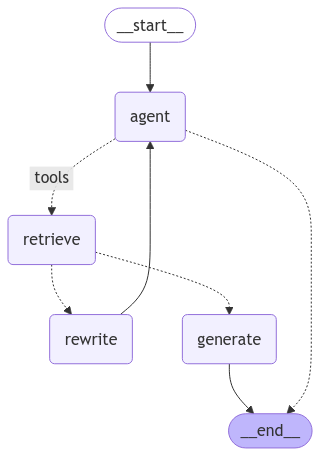

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
import pprint

# inputs = {
#     "messages": [
#         HumanMessage("What is quick sort")
#     ]
# }

inputs = {
    "messages": [
        HumanMessage("Who is obama"),
    ]
}

output = graph.invoke(inputs)
print('output:',output["messages"][-1].content)
# for output in graph.stream(inputs):
#     for key, value in output.items():
#         pprint.pprint(f"Output from node '{key}':")
#         pprint.pprint("---")
#         pprint.pprint(value, indent=2, width=80, depth=None)
#     pprint.pprint("\n---\n")

---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


No relevant docs were retrieved using the relevance score threshold 0.7


KeyboardInterrupt: 

In [ ]:
print(output["messages"][-1].content)

# Image Chain

In [1]:
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
import streamlit as st

# Initialize the LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=st.secrets["OpenAI_key"],
    temperature=0
)

C:\Users\elroy\AppData\Local\Temp\ipykernel_30700\1394110419.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [ ]:
from test_templates.image_template import image_app
def read_image_bytes(image_path):
    with open(image_path, 'rb') as image_file:
        return image_file.read()
img = read_image_bytes('test_image_1.jpeg')
import base64

image_data = base64.b64encode(img).decode("utf-8")



# image_chain = get_image_chain()

message_content = [{"type": "text", "text": "Describe the image provided"}]
message_content.append({
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}
                })

final_message = {
    "messages":[
    {
        "role": "user",
        "content": message_content,
    }],
    "user_level": "beginner"}

config = {"configurable": {"thread_id": "abc123"}}
image_app.invoke(input = final_message,config=config)

In [2]:
from utils.chunk_doc import get_retriever

def test_quicksort_retrieval():
    # Get the retriever
    retriever = get_retriever()
    
    # Test quicksort query
    query = "What is quicksort?"
    print(f"\nTesting retrieval for: {query}")
    
    try:
        # Get documents
        docs = retriever.get_relevant_documents(query)
        
        print(f"\nNumber of documents found: {len(docs)}")
        
        if len(docs) > 0:
            for i, doc in enumerate(docs, 1):
                print(f"\n--- Document {i} ---")
                print(f"Source: {doc.metadata.get('source', 'No source')}")
                print(f"Content: {doc.page_content[:200]}...")
        else:
            print("No documents were retrieved!")
            
    except Exception as e:
        print(f"Error during retrieval: {str(e)}")

# Run test
if __name__ == "__main__":
    test_quicksort_retrieval()


Testing retrieval for: What is quicksort?


No index params provided. Could not determine relevance function. Use L2 distance as default.



Number of documents found: 10

--- Document 1 ---
Source: data\md\algo1.md
Content: ###### The basic algorithm  Quicksort is a divide-and-conquer method for sorting. It

works by partitioning an array into two subarrays, then sorting the subarrays independently. Quicksort is compleme...

--- Document 2 ---
Source: data\md\algo1.md
Content: -----

###### Performance characteristics Quicksort has been subjected to very thorough

mathematical analysis, so that we can make precise statements about its performance.
The analysis has been vali...

--- Document 3 ---
Source: data\md\divide-and-conquer.md
Content: - Slower than QuickSort in general. QuickSort is more cache friendly because it works in-place.


Quick Links:



- Merge Sort Based Coding Questions

- Bottom up (or Iterative) Merge Sort

- Recent A...

--- Document 4 ---
Source: data\md\randomized-algorithms.md
Content: ### C#


```
// C# implementation of QuickSort// using Hoare's partition schemeusingSystem;publicclassGFG {// Dr